<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Slit

## Spec2: Assign_wcs()
<span style="color:red"> **Instruments Affected**</span>: FGS, MIRI, NIRCam, NIRISS, NIRSpec 

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
data_dir = TemporaryDirectory()

# If you have files that are in the notebook's directory, but that the notebook will need to use while
# running, copy them into the temporary directory here.
#
# files = ['name_of_file']
# for file_name in files:
#     shutil.copy(file_name, os.path.join(data_dir.name, file_name))

os.chdir(data_dir.name)

In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.

* os, glob for general  OS operations
* numpy
* logging
* astropy.io for opening fits files
* astropy.utils for remote data retrieval
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot
* matplotlib.patches to plot a shape
* pysiaf for SIAF access
* miricoord for coordinate conversion tools
* gwcs for wcs tools

[Top of Page](#title_ID)

In [3]:
import inspect
import numpy as np
import glob
import os
import logging
from IPython.display import Markdown
from jwst.datamodels import RampModel, ImageModel, CubeModel
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline
from jwst.assign_wcs import AssignWcsStep
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import astropy.io.fits as fits
import astropy.io.ascii as ascii
from astropy.table import Table, Column
from astropy.utils.data import download_file
from gwcs.wcstools import grid_from_bounding_box
from numpy.testing import assert_allclose

from pysiaf import Siaf
import miricoord.imager.mirim_tools as mt
import miricoord.lrs.toolversions.lrs_pipetools_cdp7 as tv
from miricoord.lrs.lrs_pipetools import xytov2v3lam

from ci_watson.artifactory_helpers import get_bigdata

%matplotlib inline


<a id="intro_ID"></a>
# Introduction


In this notebook we will test the assign_wcs step of Spec2Pipeline() for **LRS slit** observations.

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html#assign-wcs-step

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/assign_wcs


### Calibration WG Requested Algorithm: 

https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+GWCS+Information



[Top of Page](#title_ID)

<a id="data_ID"></a>
# Loading Data

We are using here a simulated LRS slit observation, generated with MIRISim v2.3.0 (as of Dec 2020). It is a simple along-slit-nodded observation of a point source (the input was modelled on the flux calibrator BD+60). LRS slit observations cover the full array. 


[Top of Page](#title_ID)

In [4]:
Slitfile1 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod1_v2.3.fits')
 
Slitfile2 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod2_v2.3.fits')

files = [Slitfile1, Slitfile2]

In [5]:
print(files)

['/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq/miri_lrs_slit_pt_nod1_v2.3.fits', '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq/miri_lrs_slit_pt_nod2_v2.3.fits']


<a id="pipeline_ID"></a>
# Run JWST Pipeline

First we run the data through the Detector1() pipeline to convert the raw counts into slopes. This should use the calwebb_detector1.cfg file. The output of this stage will then be run through the assign_wcs() step, which is part of the Spec2Pipeline. 

[Top of Page](#title_ID)

### CalDetector1

We first run the data through the Detector1 pipeline, ensuring to pass the calwebb_detector1.cfg configuration file. 

In [6]:
det1_out = []
nods = []
for ff in files:
    det1 = Detector1Pipeline.call(ff, save_results=True)
    if 'nod1' in ff:
        nodno = 'nod1'
    else:
        nodno = 'nod2'
    det1_out.append(det1)
    nods.append(nodno)

2022-06-20 14:28:47,191 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-06-20 14:28:47,215 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-06-20 14:28:47,217 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-06-20 14:28:47,218 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-06-20 14:28:47,219 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-06-20 14:28:47,221 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-06-20 14:28:47,222 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-06-20 14:28:47,223 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-06-20 14:28:47,224 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-06-20 14:28:47,225 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-06-20 14:28:47,227 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-06-20 14:28:47,228 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-06-20 14:28:47,229 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-06-20 14:28:47,230 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-06-20 14:28:47,232 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-06-20 14:28:47,233 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-06-20 14:28:47,234 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-06-20 14:28:47,235 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-06-20 14:28:47,488 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq/miri_lrs_slit_pt_nod1_v2.3.fits',).


2022-06-20 14:28:47,499 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-06-20 14:28:47,751 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod1_v2.3.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-06-20 14:28:47,851 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-06-20 14:28:47,854 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-06-20 14:28:47,856 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-06-20 14:28:47,857 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-06-20 14:28:47,860 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-06-20 14:28:47,860 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits'.


2022-06-20 14:28:47,862 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-06-20 14:28:47,863 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-06-20 14:28:47,865 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-06-20 14:28:47,867 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-06-20 14:28:47,868 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-06-20 14:28:47,869 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-06-20 14:28:47,870 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-06-20 14:28:47,871 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-06-20 14:28:48,364 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-06-20 14:28:48,367 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:28:48,532 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-06-20 14:28:48,533 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-06-20 14:28:48,537 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-06-20 14:28:48,821 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-06-20 14:28:48,824 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:28:48,860 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-06-20 14:28:49,276 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-06-20 14:28:49,567 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-06-20 14:28:49,570 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq', 'n_pix_grow_sat': 1}


2022-06-20 14:28:49,599 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-06-20 14:28:51,325 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-06-20 14:28:51,348 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-06-20 14:28:51,360 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-06-20 14:28:51,624 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-06-20 14:28:51,626 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:28:51,627 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-06-20 14:28:51,630 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-06-20 14:28:51,931 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-06-20 14:28:51,935 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:28:52,132 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-06-20 14:28:52,432 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-06-20 14:28:52,436 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:28:52,620 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-06-20 14:28:52,974 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-06-20 14:28:52,976 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:28:53,021 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-06-20 14:28:55,301 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-06-20 14:28:55,518 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-06-20 14:28:55,520 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:28:55,545 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-06-20 14:28:57,692 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-06-20 14:28:57,982 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-06-20 14:28:57,985 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq', 'type': 'baseline'}


2022-06-20 14:28:58,011 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-06-20 14:28:58,233 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-06-20 14:28:58,482 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-06-20 14:28:58,485 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq', 'dark_output': None}


2022-06-20 14:28:58,512 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-06-20 14:29:21,661 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2022-06-20 14:29:21,664 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-06-20 14:29:22,575 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-06-20 14:29:22,877 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-06-20 14:29:22,880 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-06-20 14:29:23,034 - stpipe.Detector1Pipeline.refpix - INFO - MIRI full frame data


2022-06-20 14:29:23,035 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is valid for this mode:


2022-06-20 14:29:23,036 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-06-20 14:29:23,037 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are not applicable and are ignored:


2022-06-20 14:29:23,038 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = False


2022-06-20 14:29:23,039 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = False


2022-06-20 14:29:23,040 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = False


2022-06-20 14:29:23,040 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = False


2022-06-20 14:29:23,041 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2022-06-20 14:29:23,426 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2022-06-20 14:29:23,491 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-06-20 14:29:23,772 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-06-20 14:29:23,775 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-06-20 14:29:23,793 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-06-20 14:29:23,813 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-06-20 14:29:23,895 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2022-06-20 14:29:24,166 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-06-20 14:29:24,214 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-06-20 14:29:25,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28384 pixels with at least one CR from five groups.


2022-06-20 14:29:25,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-06-20 14:29:25,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-06-20 14:29:29,993 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-06-20 14:29:31,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12669 pixels with at least one CR from five groups.


2022-06-20 14:29:31,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-06-20 14:29:31,021 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-06-20 14:29:32,888 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 8.72103 sec


2022-06-20 14:29:32,894 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.100952


2022-06-20 14:29:32,901 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-06-20 14:29:33,233 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-06-20 14:29:33,235 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-06-20 14:29:33,292 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2022-06-20 14:29:33,294 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-06-20 14:29:33,366 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-06-20 14:29:33,367 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-06-20 14:29:33,536 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-06-20 14:29:33,538 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-06-20 14:29:46,072 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-06-20 14:29:46,075 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2022-06-20 14:29:46,210 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-06-20 14:29:46,478 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-06-20 14:29:46,480 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:29:46,540 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-06-20 14:29:46,542 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-06-20 14:29:46,551 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-06-20 14:29:46,787 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-06-20 14:29:46,790 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:29:46,846 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-06-20 14:29:46,847 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-06-20 14:29:46,852 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-06-20 14:29:46,964 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rateints.fits


2022-06-20 14:29:46,965 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-06-20 14:29:46,966 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0874.pmap


2022-06-20 14:29:47,048 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rate.fits


2022-06-20 14:29:47,049 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-06-20 14:29:47,442 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-06-20 14:29:47,462 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-06-20 14:29:47,464 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-06-20 14:29:47,465 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-06-20 14:29:47,466 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-06-20 14:29:47,470 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-06-20 14:29:47,471 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-06-20 14:29:47,473 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-06-20 14:29:47,474 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-06-20 14:29:47,476 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-06-20 14:29:47,477 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-06-20 14:29:47,478 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-06-20 14:29:47,479 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-06-20 14:29:47,480 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-06-20 14:29:47,482 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-06-20 14:29:47,483 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-06-20 14:29:47,485 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-06-20 14:29:47,486 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-06-20 14:29:47,727 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq/miri_lrs_slit_pt_nod2_v2.3.fits',).


2022-06-20 14:29:47,740 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-06-20 14:29:47,930 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod2_v2.3.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-06-20 14:29:47,939 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-06-20 14:29:47,941 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-06-20 14:29:47,943 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-06-20 14:29:47,945 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-06-20 14:29:47,947 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-06-20 14:29:47,947 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits'.


2022-06-20 14:29:47,949 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-06-20 14:29:47,949 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-06-20 14:29:47,951 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-06-20 14:29:47,953 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-06-20 14:29:47,955 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-06-20 14:29:47,955 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-06-20 14:29:47,956 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-06-20 14:29:47,957 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-06-20 14:29:48,402 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-06-20 14:29:48,404 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:29:48,504 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-06-20 14:29:48,505 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-06-20 14:29:48,509 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-06-20 14:29:48,755 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-06-20 14:29:48,758 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:29:48,784 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-06-20 14:29:49,075 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-06-20 14:29:49,314 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-06-20 14:29:49,316 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq', 'n_pix_grow_sat': 1}


2022-06-20 14:29:49,342 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-06-20 14:29:50,340 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-06-20 14:29:50,355 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-06-20 14:29:50,365 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-06-20 14:29:50,598 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-06-20 14:29:50,600 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:29:50,601 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-06-20 14:29:50,604 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-06-20 14:29:50,847 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-06-20 14:29:50,850 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:29:50,970 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-06-20 14:29:51,201 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-06-20 14:29:51,202 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:29:51,304 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-06-20 14:29:51,547 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-06-20 14:29:51,549 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:29:51,580 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-06-20 14:29:51,972 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-06-20 14:29:52,234 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-06-20 14:29:52,237 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:29:52,264 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-06-20 14:29:52,830 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-06-20 14:29:53,059 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-06-20 14:29:53,061 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq', 'type': 'baseline'}


2022-06-20 14:29:53,088 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-06-20 14:29:53,247 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-06-20 14:29:53,484 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-06-20 14:29:53,487 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq', 'dark_output': None}


2022-06-20 14:29:53,517 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-06-20 14:29:55,257 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2022-06-20 14:29:55,258 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-06-20 14:29:56,139 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-06-20 14:29:56,310 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-06-20 14:29:56,312 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-06-20 14:29:56,433 - stpipe.Detector1Pipeline.refpix - INFO - MIRI full frame data


2022-06-20 14:29:56,435 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is valid for this mode:


2022-06-20 14:29:56,435 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-06-20 14:29:56,436 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are not applicable and are ignored:


2022-06-20 14:29:56,437 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = False


2022-06-20 14:29:56,437 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = False


2022-06-20 14:29:56,438 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = False


2022-06-20 14:29:56,439 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = False


2022-06-20 14:29:56,443 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2022-06-20 14:29:56,760 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2022-06-20 14:29:56,815 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-06-20 14:29:56,954 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-06-20 14:29:56,956 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-06-20 14:29:56,966 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-06-20 14:29:56,980 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-06-20 14:29:57,017 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2022-06-20 14:29:57,232 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-06-20 14:29:57,291 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-06-20 14:29:58,453 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28153 pixels with at least one CR from five groups.


2022-06-20 14:29:58,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-06-20 14:29:58,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-06-20 14:30:02,519 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-06-20 14:30:03,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12958 pixels with at least one CR from five groups.


2022-06-20 14:30:03,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-06-20 14:30:03,792 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-06-20 14:30:05,374 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 8.14074 sec


2022-06-20 14:30:05,378 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 8.411393


2022-06-20 14:30:05,384 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-06-20 14:30:05,548 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-06-20 14:30:05,550 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-06-20 14:30:05,586 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2022-06-20 14:30:05,587 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-06-20 14:30:05,640 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-06-20 14:30:05,641 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-06-20 14:30:05,792 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-06-20 14:30:05,794 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-06-20 14:30:19,279 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-06-20 14:30:19,281 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2022-06-20 14:30:19,381 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-06-20 14:30:19,551 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-06-20 14:30:19,553 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:30:19,600 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-06-20 14:30:19,601 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-06-20 14:30:19,605 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-06-20 14:30:19,741 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-06-20 14:30:19,743 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp77v7nnyq'}


2022-06-20 14:30:19,787 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-06-20 14:30:19,788 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-06-20 14:30:19,793 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-06-20 14:30:19,893 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rateints.fits


2022-06-20 14:30:19,894 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-06-20 14:30:19,895 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0874.pmap


2022-06-20 14:30:19,963 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rate.fits


2022-06-20 14:30:19,964 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


### AssignWcs

The AssignWcs step should not change anything in the science data or error extension. It attaches the WCS information to the data, so that a location in detector pixels can be reconstructed to an RA, dec, wavelength in spatial and spectral space. 

In [7]:
awcs_out = []

for dd in det1_out:
    awcs = AssignWcsStep.call(dd,save_results=True) 
    awcs_out.append(awcs)

2022-06-20 14:30:19,989 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-06-20 14:30:20,132 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-06-20 14:30:20,134 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-06-20 14:30:20,466 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-06-20 14:30:20,559 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2022-06-20 14:30:20,560 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2022-06-20 14:30:20,561 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-06-20 14:30:20,574 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0874.pmap


2022-06-20 14:30:20,745 - stpipe.AssignWcsStep - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits


2022-06-20 14:30:20,746 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-06-20 14:30:20,756 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-06-20 14:30:20,906 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-06-20 14:30:20,908 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-06-20 14:30:21,171 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-06-20 14:30:21,259 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2022-06-20 14:30:21,260 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2022-06-20 14:30:21,261 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-06-20 14:30:21,274 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0874.pmap


2022-06-20 14:30:21,443 - stpipe.AssignWcsStep - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits


2022-06-20 14:30:21,444 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


<a id="residual_ID"></a>
## Output checks and tests

We can use the output model to run the following checks:

* the SCI extension is unchanged from the step input (accept default tolerances for the np.allclose() function)
* we visualize the location of the bounding box.
* we use the wcs information assigned in the step to check the RA, dec, wavelength assignment at some reference locations. 

For LRS slit, the bounding box is defined from the wave/distortion reference file, as follows:

``bb_sub = ((np.floor(x0.min() + zero_point[0]) - 0.5, np.ceil(x1.max() + zero_point[0]) + 0.5),
                  (np.floor(y2.min() + zero_point[1]) - 0.5, np.ceil(y0.max() + zero_point[1]) + 0.5))``

where ``x0`` is the x-coordinate of the top-left corner, ``x1`` of the top-right corner, ``y0`` the y-coordinate of the top-left corner, ``y2`` of the bottom-right corner. ``zero_point`` is the slit centre coordiate as defined in the IMX and IMY header keywords. The 0.5 is to account for different pixel counting conventions.

[Top of Page](#title_ID)

In [8]:
# Do a numeric check between input and output
for (aa, dd, nn) in zip(awcs_out, det1_out, nodno):
    try:
        assert np.allclose(aa.data, dd.data, equal_nan=True)
    except:
        print("Step input and output don't match for {}".format(nodno))
    #assert np.allclose(aa.data, dd.data, equal_nan=True), "Step input and output don't match for {}".format(nodno)

In [9]:
for aa, nn in zip(awcs_out, nods):

    bbox_w = aa.meta.wcs.bounding_box[0][1] - aa.meta.wcs.bounding_box[0][0]
    bbox_ht = aa.meta.wcs.bounding_box[1][1] - aa.meta.wcs.bounding_box[1][0]
    print('Model bbox ({1})= {0} '.format(aa.meta.wcs.bounding_box, nn))
    print('Model: Height x width of bounding box ({2})= {0} x {1} pixels'.format(bbox_ht, bbox_w, nn))
    
# Check that the bounding boxes are the same for both nods:
try:
    assert awcs_out[0].meta.wcs.bounding_box == awcs_out[1].meta.wcs.bounding_box
except:
    print("Bounding box for nod positions don't match")

#assert awcs_out[0].meta.wcs.bounding_box == awcs_out[1].meta.wcs.bounding_box, "Bounding box for nod positions don't match"

Model bbox (nod1)= ModelBoundingBox(
    intervals={
        x0: Interval(lower=302.5, upper=346.5)
        x1: Interval(lower=6.5, upper=396.5)
    }
    model=CompoundModel(inputs=('x0', 'x1'))
    order='C'
) 
Model: Height x width of bounding box (nod1)= 390.0 x 44.0 pixels
Model bbox (nod2)= ModelBoundingBox(
    intervals={
        x0: Interval(lower=302.5, upper=346.5)
        x1: Interval(lower=6.5, upper=396.5)
    }
    model=CompoundModel(inputs=('x0', 'x1'))
    order='C'
) 
Model: Height x width of bounding box (nod2)= 390.0 x 44.0 pixels


(1024, 1032)

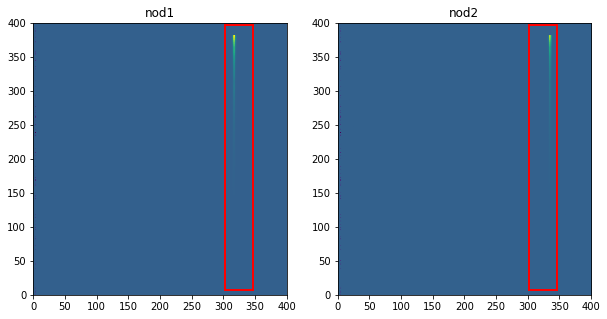

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[10,5])

bbox0 = Rectangle((awcs_out[0].meta.wcs.bounding_box[0][0],awcs_out[0].meta.wcs.bounding_box[1][0]), bbox_w, bbox_ht, angle=0.0, ec='r', lw=2, fc='None')
bbox1 = Rectangle((awcs_out[1].meta.wcs.bounding_box[0][0],awcs_out[1].meta.wcs.bounding_box[1][0]), bbox_w, bbox_ht, angle=0.0, ec='r', lw=2, fc='None')

ax[0].imshow(awcs_out[0].data, origin='lower', interpolation='None', aspect='auto')
ax[0].add_patch(bbox0)
ax[0].set_xlim([0,400])
ax[0].set_ylim([0,400])
ax[0].set_title(nods[0])

ax[1].imshow(awcs_out[1].data, origin='lower', interpolation='None', aspect='auto')
ax[1].add_patch(bbox1)
ax[1].set_xlim([0,400])
ax[1].set_ylim([0,400])
ax[1].set_title(nods[1])

np.shape(awcs_out[0].data)

In [11]:
# Plot the wavelength solution based on the wcs information in the model
siaf = Siaf('MIRI')
ap = siaf['MIRIM_SLIT']
refpx_tel = ap.reference_point(to_frame='tel')
refpx_abs = mt.v2v3toxy(refpx_tel[0], refpx_tel[1], filter='F770W')
refpx = (refpx_abs[0] - awcs_out[0].meta.wcs.bounding_box[0][0], refpx_abs[1] - awcs_out[0].meta.wcs.bounding_box[1][0])
#print(refpx)

x,y = grid_from_bounding_box(awcs_out[0].meta.wcs.bounding_box)
ra, dec, lam = awcs_out[0].meta.wcs(x, y)

fig = plt.figure(figsize=[6,10])
imlam=plt.imshow(lam, origin='lower', interpolation='None')
cbar = fig.colorbar(imlam)
plt.scatter(refpx[0], refpx[1], marker='x', color='r')

FileNotFoundError: [Errno 2] No such file or directory: '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/data/fits/flt1/MIRI_FM_MIRIMAGE_DISTORTION_SS.04.00.fits'

Load the set of test coordinates from ``miricoord``. Then calculate the wavelength of these coordinates from the assign_wcs output models, and verify that they are close. If all the ``assert`` tests pass, this test is successful and complete.

In [ ]:
xt,yt,v2t,v3t,lamt,stype=tv.testdata()

lamtest1 = np.zeros(3)
lamtest2 = np.zeros(3)
v2test1 = np.zeros(3)
v3test1 = np.zeros(3)
lt1 = np.zeros(3)

print('**** TEST SET ****')
print(' x       y     lam_truth  lamtest1  lamtest2  v2truth   v3truth  v2test   v3test')
for i in range (3):
    v2test1[i], v3test1[i], lt1[i] = xytov2v3lam(xt[0][i], yt[0][i], 'slit') 
    ra, dec, lamtest1[i] = awcs_out[0].meta.wcs(xt[0][i], yt[0][i])
    ra, dec, lamtest2[i] = awcs_out[1].meta.wcs(xt[0][i], yt[0][i])
    print('{0}  {1}   {2}    {3:.5f}    {4:.5f}  {5:.5f}   {6:.5f}   {7:.5f}   {8:.5f}'.format(xt[0][i], yt[0][i], lamt[0][i], lamtest1[i], lamtest2[i], v2t[0][i], v3t[0][i], v2test1[i], v3test1[i]))
    
    try:
        assert_allclose(lamt[0][i], lamtest1[i], atol=0.05)
    except:
        print("AssertError: assert1 failed")
        
    try:    
        assert_allclose(lamt[0][i], lamtest2[i], atol=0.05)
    except:
        print("AssertError: assert2 failed")
        
    try:    
        assert_allclose(v2t[0][i], v2test1[i], atol=0.05)
    except:
        print("AssertError: assert3 failed")

    try:    
        assert_allclose(v3t[0][i], v3test1[i], atol=0.05)
    except:
        print("AssertError: assert4 failed")
        

<a id="about_ID"></a>
## About this Notebook
**Author:** Sarah Kendrew, ESA MIRI Instrument & Calibration Scientist, MIRI branch
<br>**Updated On:** 12/08/2020

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 